<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>SVM, Kernel Trick (практика)</center></h2>

**Срок сдачи:** 23 декабря 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 23 декабря, -4 балла после 06:00 30 декабря, -6 баллов после 06:00 6 января

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

import warnings
warnings.filterwarnings('ignore')

# Регрессия с SVM (3 балла)

Загрузите набор данных из *titanium.csv*<br/>
Мы будем решать задачу восстановления столбца 'y' по столбцу 'x'.

## Визуализация данных (1 балл)

Выполните стандартную предобработку данных (z-score) и выведите их на графике.

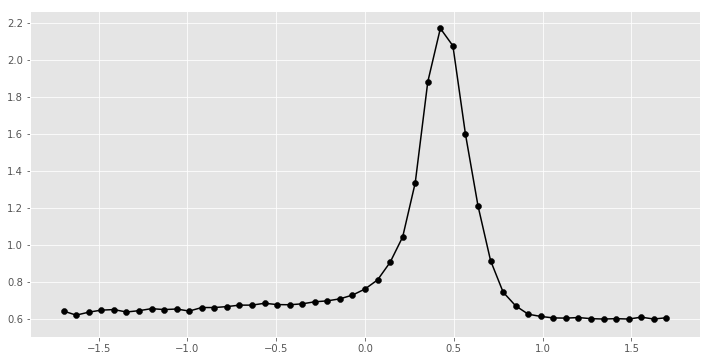

In [3]:
df = pd.read_csv('titanium.csv')

X = df.x.values.reshape(-1, 1)
X = (X - X.mean()) / X.std()
y = df.y.values

plt.plot(X, y, c='k')
plt.scatter(X, y, c='k');


## Обучение моделей (2 балла)

Рассмотрите 3 ядра: 
* Линейное
* Полиномиальное (degree = 3, gamma = 6, coef0 = 1)
* RBF (gamma = 6, coef0 = 1)

Во всех случаях установить ширину трубки `epsilon=0.01`

Для каждого из ядер:
1. Пусть `C = np.logspace(-2, 2, 10)`. Постройте графики зависимости ошибки от параметра $C$ (ось графика со значениями параметра $C$ должна быть в логарифмической шкале). Ошибка измеряется как средняя абсолютная ошибка. 
2. Для наилучшего параметра $С$ каждого из ядер постройте график с данными и предсказанием по svm.

В каких случаях возникают эффекты недообучения, переобучения?

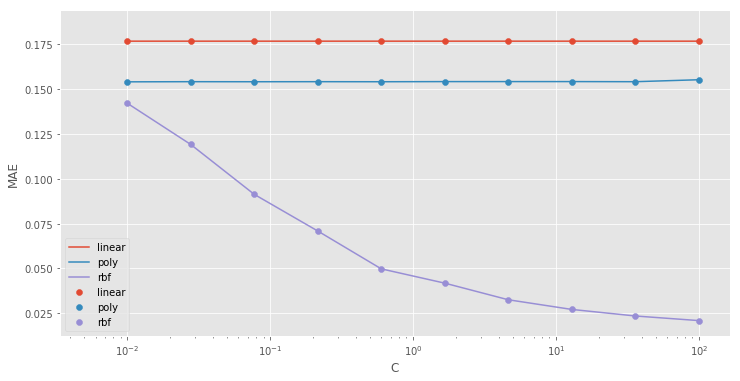

In [4]:
# Penalty parameter C of the error term.
C = np.logspace(-2, 2, 10)

MAE = np.zeros((3, len(C)))

# eps - допустимое отклонение для результата (epsilon-tube).
# gamma - kernel coefficient for ‘rbf’, ‘poly’.
# coef0 - independent term in kernel function.
parameters = [{'kernel': 'linear', 'epsilon' : 0.01},\
          {'kernel': 'poly', 'degree': 3, 'gamma': 6, 'coef0': 1, 'epsilon' : 0.01},\
          {'kernel': 'rbf', 'gamma': 6, 'coef0': 1, 'epsilon' : 0.01}]

for i, c in enumerate(C):
    for j, parameter in enumerate(parameters):

        model = SVR(C=c, **parameter)
        model.fit(X, y)
        y_predict = model.predict(X)
        MAE[j, i] = mean_absolute_error(y, y_predict)

for i, parameter in enumerate(parameters):
    
    plt.scatter(C, MAE[i], label=parameter.get('kernel'))
    plt.plot(C, MAE[i], label=parameter.get('kernel'))

plt.xscale('log')
plt.ylabel('MAE')
plt.xlabel('C')
plt.legend();


Из полученных графиков видно, что линейное и полиномиальное ядра, в отличие от ядра RBF, которое недообучено при малых С, почти не изменяются. 

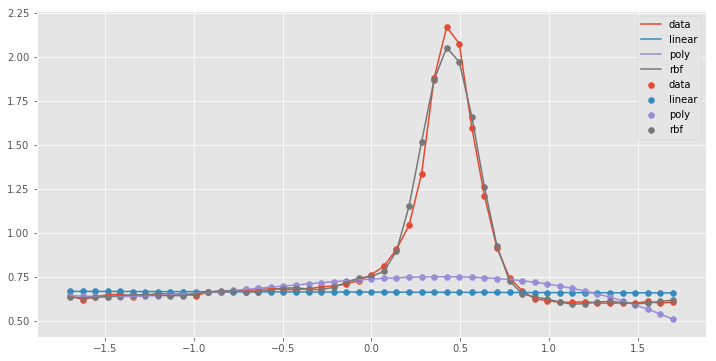

In [5]:
models = MAE.argmin(axis=1)

plt.scatter(X, df.y, label='data')
plt.plot(X, df.y, label='data')

for i, parameter in enumerate(parameters):
    
    model = SVR(C=C[models[i]], **parameter)
    model.fit(X, y)
    y_predict = model.predict(X)
    
    plt.scatter(X, y_predict, label=parameter.get('kernel'))
    plt.plot(X, y_predict, label=parameter.get('kernel'))

plt.legend();


# Определение языка слова (7 баллов)

В данном задании вам необходимо определить, на каком языке написано слово.

Вам будет дано два текста - первые предложения произведения "Война и Мир" на английком и испанском, разбитые на слова. У слов нет общепринятого числового представления, поэтому мы предлагаем вам реализовать собственноге ядро для SVM, основанное на редакторском расстоянии или [расстоянии Левенштейна](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B5%D0%B2%D0%B5%D0%BD%D1%88%D1%82%D0%B5%D0%B9%D0%BD%D0%B0). 

Имплементировать расстояние Левенштейна не нужно - можно взять любую доступную реализацию, например [здесь](https://github.com/toastdriven/pylev) или [здесь](https://github.com/ztane/python-Levenshtein).

In [30]:
import pylev
from pylev import levenshtein


## Загрузка (1 балл)

Загрузите данные из файлов *war_and_peace_es.txt* и *war_and_peace_en.txt*.<br/> 
В результате вы должны получить pandas.DataFrame со столбцами *index* | *word* | *label*, где *index* - это индекс pandas, *word* - это слово и *label* - это метка класса (0 или 1)

In [7]:
df_en = pd.read_csv("war_and_peace_en.txt", names=['words'])
df_es = pd.read_csv("war_and_peace_es.txt", names=['words'])
df_en['label'] = 0
df_es['label'] = 1

df = pd.concat([df_en, df_es], ignore_index=True)

df.head()

,words,label
0,war,0
1,and,0
2,peace,0
3,leo,0
4,tolstoy,0


## Подготовка данных (2 балла)

Особенностью пользовательского ядра в sklean.SVC является то, что на вход оно должно принимать именно вектора чисел.<br/>
В нашем случае это будут индексы соответствующих слов из корпуса. То есть вместо вектора ['treat', 'celebrit', 'prince', ...] на вход в ядро подается вектор из индексов [9209, 11145, 7735, ...] с помощью которых вы будете находить сами слова.

Прежде чем мы начнем строить ядро, надо подготовить данные. Для этого:
1. Задайте переменную RND_SEED, которая будет использоваться в любых генераторах случайных чисел в вашем коде (обычно параметр "random_seed")
2. Случайным образом перемешайте и заново проиндексируйте таблицу, полученную выше (используйте методы df.sample() и df.reset_index())
3. Ядро может вычисляться достаточно долго, поэтому можете урезать таблицу, но оставить в ней не менее 1000 слов.
4. Разбейте данные на обучающую и контрольную выборку в пропорции 60/40

В результате вы должны получить вектор-столбец X_train, X_test с **индексами** слов и векторы y_train, y_test с метками классов.

In [23]:
RND_SEED = 100
NUM_WORDS = 2000

df = df.sample(frac=1, random_state=RND_SEED).reset_index(drop=True)

df_part = df[:NUM_WORDS]

X = df_part.index.values
y = df_part.label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RND_SEED)

print(X_train[:10])
print(X_test[:10])


[ 747 1335   66 1637 1537  903  636  968 1684  713]
[1025 1208 1055  367  815  372  573 1186 1590 1841]


## Расчет ядра (3 балла)

Некоторые указания по составлению пользовательского ядра можно найти [здесь](http://stackoverflow.com/questions/26962159/how-to-use-a-custom-svm-kernel).

Если в двух словах:<br/>
Функция, реализующая расчет ядра должна принимать две матрицы $U$ и $V$ с признаковым описанием объектов (во время обучения они обе относятся к обучающей выборке, а во время применения - одна матрица относится к обучающей выборке, а другая к контрольной).

В результате, функция должна возвращать матрицу ядра $G_{ij} = K(U_i, V_j)$.

Таким образом, в этом задании вам надо:
1. Написать функцию *string_kernel(U, V)*, расчитывающее матрицу ядра $G_{ij}$
2. Визуализировать матрицу только для обучающей выборки (функция plt.imshow()).

**ВАЖНО**<br/>
На лекции мы рассмотрели, что ядро должно обладать определенными свойствами, поэтому не получится рассчитать $G_{ij}$ как расстояние Левенштейна между словами $\text{word}_i$ и $\text{word}_j$.<br/>
Вместо этого используйте какое-нибудь готовое ядро, зависящее от расстояние между объектами.

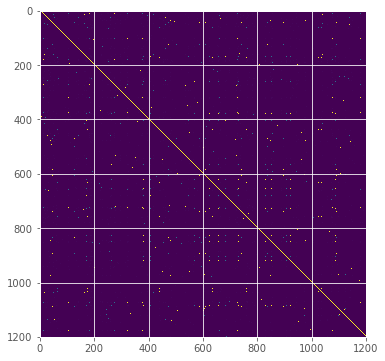

In [31]:
def string_kernel(U, V):
    
    G = np.empty((U.shape[0], V.shape[0]))
    
    for i, uword in enumerate(U):
        
        for j, vword in enumerate(V):
            
            G[i, j] = np.exp(-levenshtein(df_part.words[uword], df_part.words[vword])**2)
    
    return G

G_train = string_kernel(X_train, X_train)
plt.imshow(G_train)


In [25]:
G_test = string_kernel(X_test, X_train)


## Оценка качества (1 балл)

Обучите метод опорных векторов с различными значениями параметра штрафа $C$.<br/>
Для каждого значения выведите accuracy на обучающей и контрольной выборке.

Постарайтесь достичь качества в 70% на тестовой выборке

In [26]:
C = np.logspace(-2, 2, 100)

train_error = []
test_error = []

for c in C:
    
    svc = SVC(C=c, kernel="precomputed", random_state=RND_SEED)
    svc.fit(G_train, y_train)
    
    train_error.append(accuracy_score(y_train, svc.predict(G_train)))
    test_error.append(accuracy_score(y_test, svc.predict(G_test)))
    

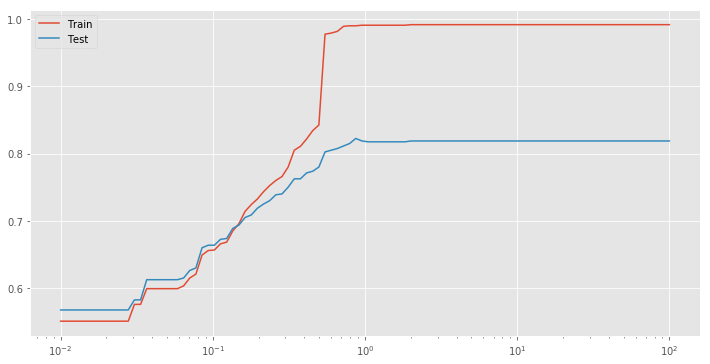

In [27]:
plt.plot(C, train_error, label='Train')
plt.plot(C, test_error, label='Test')

plt.xscale('log')
plt.legend();


In [28]:
print 'test_best: ', round(max(test_error), 2)
print 'train_best: ', round(max(train_error), 2)


test_best:  0.82
train_best:  0.99
